# Batch Normalization

In this notebook, you will implement the batch normalization layers of a neural network to increase its performance.  Please review the details of batch normalization from the lecture notes.

CS231n has built a solid API for building these modular frameworks and training them, and we will use their very well implemented framework as opposed to "reinventing the wheel."  This includes using their Solver, various utility functions, and their layer structure.  This also includes nndl.fc_net, nndl.layers, and nndl.layer_utils.  As in prior assignments, we thank Serena Yeung & Justin Johnson for permission to use code written for the CS 231n class (cs231n.stanford.edu).  

In [1]:
## Import and setups

import time
import numpy as np
import matplotlib.pyplot as plt
from nndl.fc_net import *
from nndl.layers import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k in data.keys():
  print('{}: {} '.format(k, data[k].shape))

X_train: (49000, 3, 32, 32) 
y_train: (49000,) 
X_val: (1000, 3, 32, 32) 
y_val: (1000,) 
X_test: (1000, 3, 32, 32) 
y_test: (1000,) 


## Batchnorm forward pass

Implement the training time batchnorm forward pass, `batchnorm_forward`, in `nndl/layers.py`. After that, test your implementation by running the following cell.

In [3]:
# Check the training-time forward pass by checking means and variances
# of features both before and after batch normalization

# Simulate the forward pass for a two-layer network
N, D1, D2, D3 = 200, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

print('Before batch normalization:')
print('  means: ', a.mean(axis=0))
print('  stds: ', a.std(axis=0))

# Means should be close to zero and stds close to one
print('After batch normalization (gamma=1, beta=0)')
a_norm, _ = batchnorm_forward(a, np.ones(D3), np.zeros(D3), {'mode': 'train'})
print('  mean: ', a_norm.mean(axis=0))
print('  std: ', a_norm.std(axis=0))

# Now means should be close to beta and stds close to gamma
gamma = np.asarray([1.0, 2.0, 3.0])
beta = np.asarray([11.0, 12.0, 13.0])
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print('After batch normalization (nontrivial gamma, beta)')
print('  means: ', a_norm.mean(axis=0))
print('  stds: ', a_norm.std(axis=0))

Before batch normalization:
  means:  [-8.28501211  7.30732698 34.05258936]
  stds:  [29.49864694 28.91414292 36.68761364]
After batch normalization (gamma=1, beta=0)
  mean:  [-1.51840346e-16 -1.40235046e-16  3.30291350e-16]
  std:  [0.99999999 0.99999999 1.        ]
After batch normalization (nontrivial gamma, beta)
  means:  [11. 12. 13.]
  stds:  [0.99999999 1.99999999 2.99999999]


Implement the testing time batchnorm forward pass, `batchnorm_forward`, in `nndl/layers.py`. After that, test your implementation by running the following cell.

In [4]:
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.

N, D1, D2, D3 = 200, 50, 60, 3
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)

bn_param = {'mode': 'train'}
gamma = np.ones(D3)
beta = np.zeros(D3)
for t in np.arange(50):
  X = np.random.randn(N, D1)
  a = np.maximum(0, X.dot(W1)).dot(W2)
  batchnorm_forward(a, gamma, beta, bn_param)
bn_param['mode'] = 'test'
X = np.random.randn(N, D1)
a = np.maximum(0, X.dot(W1)).dot(W2)
a_norm, _ = batchnorm_forward(a, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After batch normalization (test-time):')
print('  means: ', a_norm.mean(axis=0))
print('  stds: ', a_norm.std(axis=0))

After batch normalization (test-time):
  means:  [ 0.00859409 -0.12663935 -0.05731522]
  stds:  [0.96596408 1.06463393 1.07007608]


## Batchnorm backward pass

Implement the backward pass for the batchnorm layer, `batchnorm_backward` in `nndl/layers.py`.  Check your implementation by running the following cell.

In [5]:
# Gradient check batchnorm backward pass

N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
fx = lambda x: batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: batchnorm_forward(x, gamma, beta, bn_param)[0]
fb = lambda b: batchnorm_forward(x, gamma, beta, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma, dout)
db_num = eval_numerical_gradient_array(fb, beta, dout)

_, cache = batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = batchnorm_backward(dout, cache)
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  2.8547115297306137e-09
dgamma error:  1.3312568072692483e-11
dbeta error:  3.275450071580837e-12


## Implement a fully connected neural network with batchnorm layers

Modify the `FullyConnectedNet()` class in `nndl/fc_net.py` to incorporate batchnorm layers.  You will need to modify the class in the following areas:

(1) The gammas and betas need to be initialized to 1's and 0's respectively in `__init__`.

(2) The `batchnorm_forward` layer needs to be inserted between each affine and relu layer (except in the output layer) in a forward pass computation in `loss`.  You may find it helpful to write an `affine_batchnorm_relu()` layer in `nndl/layer_utils.py` although this is not necessary.

(3) The `batchnorm_backward` layer has to be appropriately inserted when calculating gradients.

After you have done the appropriate modifications, check your implementation by running the following cell.

Note, while the relative error for W3 should be small, as we backprop gradients more, you may find the relative error increases.  Our relative error for W1 is on the order of 1e-4.

In [6]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64,
                            use_batchnorm=True)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('{} relative error: {}'.format(name, rel_error(grad_num, grads[name])))
  if reg == 0: print('\n')

Running check with reg =  0
Initial loss:  2.2749114664923695
BN0beta relative error: 7.32536783173746e-09
BN0gamma relative error: 7.256723450177869e-09
BN1beta relative error: 6.791259720238933e-09
BN1gamma relative error: 1.0805898594655298e-08
W0 relative error: 0.00018074255323648132
W1 relative error: 6.949623442982944e-06
W2 relative error: 3.4201719694953457e-10
b0 relative error: 1.0658141036401503e-06
b1 relative error: 9.436895709313831e-07
b2 relative error: 1.4569849558313182e-10


Running check with reg =  3.14
Initial loss:  6.663298041223118
BN0beta relative error: 8.334467214534762e-09
BN0gamma relative error: 4.424498283944529e-09
BN1beta relative error: 3.0286100590074195e-09
BN1gamma relative error: 4.5430147330239165e-09
W0 relative error: 1.7196958668928946e-05
W1 relative error: 1.6537765474805592e-06
W2 relative error: 2.168715979063564e-08
b0 relative error: 1.4432899320127035e-07
b1 relative error: 2.7755575615628914e-08
b2 relative error: 2.1261596859199332e-

## Training a deep fully connected network with batch normalization.

To see if batchnorm helps, let's train a deep neural network with and without batch normalization.

In [7]:
# Try training a very deep net with batchnorm
hidden_dims = [100, 100, 100, 100, 100]

num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 2e-2
bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=True)
model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=False)

bn_solver = Solver(bn_model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=200)
bn_solver.train()

solver = Solver(model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=200)
solver.train()

(Iteration 1 / 200) loss: 2.303963
(Epoch 0 / 10) train acc: 0.115000; val_acc: 0.103000
(Epoch 1 / 10) train acc: 0.349000; val_acc: 0.269000
(Epoch 2 / 10) train acc: 0.434000; val_acc: 0.318000
(Epoch 3 / 10) train acc: 0.504000; val_acc: 0.316000
(Epoch 4 / 10) train acc: 0.554000; val_acc: 0.335000
(Epoch 5 / 10) train acc: 0.576000; val_acc: 0.339000
(Epoch 6 / 10) train acc: 0.659000; val_acc: 0.330000
(Epoch 7 / 10) train acc: 0.688000; val_acc: 0.332000
(Epoch 8 / 10) train acc: 0.752000; val_acc: 0.325000
(Epoch 9 / 10) train acc: 0.758000; val_acc: 0.324000
(Epoch 10 / 10) train acc: 0.792000; val_acc: 0.342000
(Iteration 1 / 200) loss: 2.302716
(Epoch 0 / 10) train acc: 0.135000; val_acc: 0.137000
(Epoch 1 / 10) train acc: 0.190000; val_acc: 0.184000
(Epoch 2 / 10) train acc: 0.291000; val_acc: 0.245000
(Epoch 3 / 10) train acc: 0.386000; val_acc: 0.293000
(Epoch 4 / 10) train acc: 0.392000; val_acc: 0.297000
(Epoch 5 / 10) train acc: 0.375000; val_acc: 0.252000
(Epoch 6 / 

C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes cur

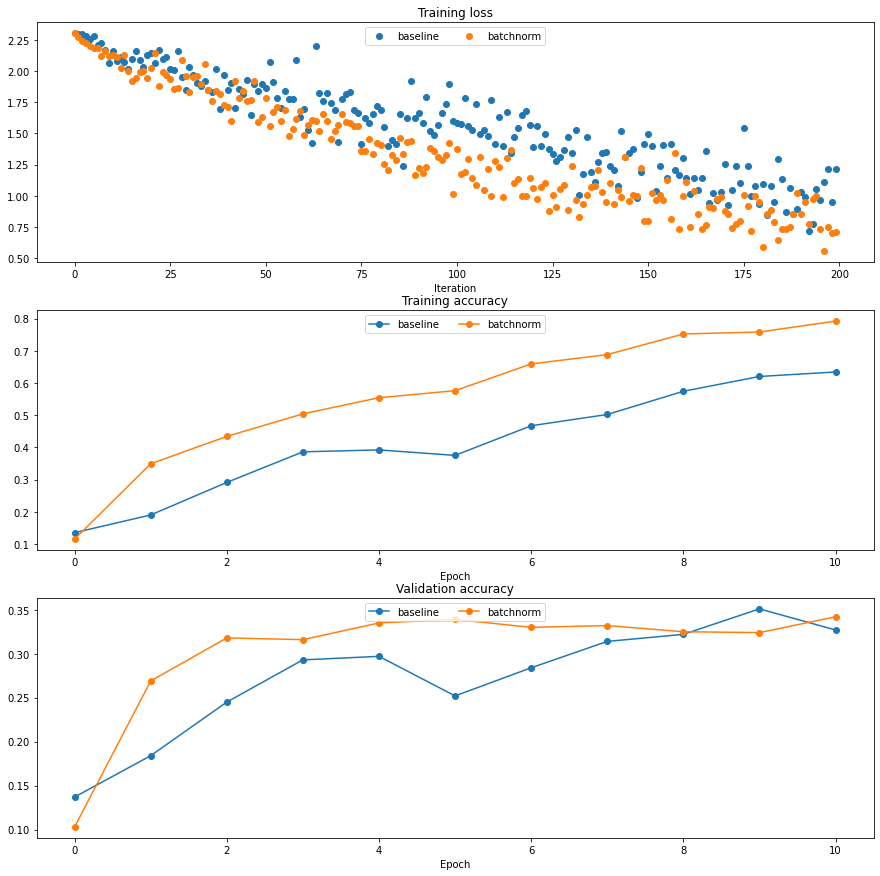

In [8]:
plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 1)
plt.plot(solver.loss_history, 'o', label='baseline')
plt.plot(bn_solver.loss_history, 'o', label='batchnorm')

plt.subplot(3, 1, 2)
plt.plot(solver.train_acc_history, '-o', label='baseline')
plt.plot(bn_solver.train_acc_history, '-o', label='batchnorm')

plt.subplot(3, 1, 3)
plt.plot(solver.val_acc_history, '-o', label='baseline')
plt.plot(bn_solver.val_acc_history, '-o', label='batchnorm')
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

## Batchnorm and initialization

The following cells run an experiment where for a deep network, the initialization is varied.  We do training for when batchnorm layers are and are not included.

In [11]:
# Try training a very deep net with batchnorm
hidden_dims = [50, 50, 50, 50, 50, 50, 50]

num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

bn_solvers = {}
solvers = {}
weight_scales = np.logspace(-4, 0, num=20)
for i, weight_scale in enumerate(weight_scales):
  print('Running weight scale {} / {}'.format(i + 1, len(weight_scales)))
  bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=True)
  model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, use_batchnorm=False)

  bn_solver = Solver(bn_model, small_data,
                  num_epochs=10, batch_size=50,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  verbose=False, print_every=200)
  bn_solver.train()
  bn_solvers[weight_scale] = bn_solver

  solver = Solver(model, small_data,
                  num_epochs=10, batch_size=50,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  verbose=False, print_every=200)
  solver.train()
  solvers[weight_scale] = solver

Running weight scale 1 / 20
Running weight scale 2 / 20
Running weight scale 3 / 20
Running weight scale 4 / 20
Running weight scale 5 / 20
Running weight scale 6 / 20
Running weight scale 7 / 20
Running weight scale 8 / 20
Running weight scale 9 / 20
Running weight scale 10 / 20
Running weight scale 11 / 20
Running weight scale 12 / 20
Running weight scale 13 / 20
Running weight scale 14 / 20
Running weight scale 15 / 20
Running weight scale 16 / 20
Running weight scale 17 / 20
Running weight scale 18 / 20
Running weight scale 19 / 20
Running weight scale 20 / 20


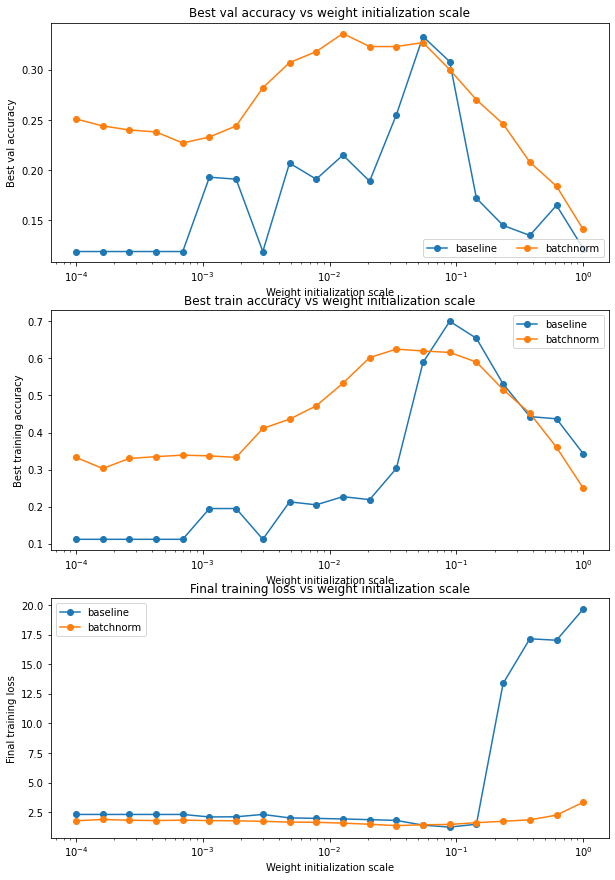

In [12]:
# Plot results of weight scale experiment
best_train_accs, bn_best_train_accs = [], []
best_val_accs, bn_best_val_accs = [], []
final_train_loss, bn_final_train_loss = [], []

for ws in weight_scales:
  best_train_accs.append(max(solvers[ws].train_acc_history))
  bn_best_train_accs.append(max(bn_solvers[ws].train_acc_history))
  
  best_val_accs.append(max(solvers[ws].val_acc_history))
  bn_best_val_accs.append(max(bn_solvers[ws].val_acc_history))
  
  final_train_loss.append(np.mean(solvers[ws].loss_history[-100:]))
  bn_final_train_loss.append(np.mean(bn_solvers[ws].loss_history[-100:]))
  
plt.subplot(3, 1, 1)
plt.title('Best val accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best val accuracy')
plt.semilogx(weight_scales, best_val_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_val_accs, '-o', label='batchnorm')
plt.legend(ncol=2, loc='lower right')

plt.subplot(3, 1, 2)
plt.title('Best train accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best training accuracy')
plt.semilogx(weight_scales, best_train_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_train_accs, '-o', label='batchnorm')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Final training loss vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Final training loss')
plt.semilogx(weight_scales, final_train_loss, '-o', label='baseline')
plt.semilogx(weight_scales, bn_final_train_loss, '-o', label='batchnorm')
plt.legend()

plt.gcf().set_size_inches(10, 15)
plt.show()

## Question:

In the cell below, summarize the findings of this experiment, and WHY these results make sense.

## Answer:

We see that batch normalizatino allows us to be invariant to some extent to the weight initialization, in the sense that the batch normalization does not suffer as much on accuracy and loss as not using batch normalization. However, when the weights are set correctly (to a good starting point) then batch norm performs roughly around the same as not using batch norm. Batch normalization almost always performed better than not using batch normalization, and as shown in the final training loss, the loss for not using batch normalization skyrocketed when the weight initializatin scale was over $10^{-1}$ while the batch normalization slightly increased in comparison.

In class we saw that if we do not use a Xavier or He initialization, if initializations too small or too large are, the activation units went to zero or exploded, but the Batch Normalization normalizes the activation unit statistics such that empirically the activation units do not saturate or explode which reduces the strong dependence on initialization.

## layers.py

In [ ]:
def batchnorm_forward(x, gamma, beta, bn_param):
    """
    Forward pass for batch normalization.

    During training the sample mean and (uncorrected) sample variance are
    computed from minibatch statistics and used to normalize the incoming data.
    During training we also keep an exponentially decaying running mean of the mean
    and variance of each feature, and these averages are used to normalize data
    at test-time.

    At each timestep we update the running averages for mean and variance using
    an exponential decay based on the momentum parameter:

    running_mean = momentum * running_mean + (1 - momentum) * sample_mean
    running_var = momentum * running_var + (1 - momentum) * sample_var

    Note that the batch normalization paper suggests a different test-time
    behavior: they compute sample mean and variance for each feature using a
    large number of training images rather than using a running average. For
    this implementation we have chosen to use running averages instead since
    they do not require an additional estimation step; the torch7 implementation
    of batch normalization also uses running averages.

    Input:
    - x: Data of shape (N, D)
    - gamma: Scale parameter of shape (D,)
    - beta: Shift paremeter of shape (D,)
    - bn_param: Dictionary with the following keys:
    - mode: 'train' or 'test'; required
    - eps: Constant for numeric stability
    - momentum: Constant for running mean / variance.
    - running_mean: Array of shape (D,) giving running mean of features
    - running_var Array of shape (D,) giving running variance of features

    Returns a tuple of:
    - out: of shape (N, D)
    - cache: A tuple of values needed in the backward pass
    """
    mode = bn_param['mode']
    eps = bn_param.get('eps', 1e-5)
    momentum = bn_param.get('momentum', 0.9)

    N, D = x.shape
    running_mean = bn_param.get('running_mean', np.zeros(D, dtype=x.dtype))
    running_var = bn_param.get('running_var', np.zeros(D, dtype=x.dtype))

    out, cache = None, None
    if mode == 'train':

    # ================================================================ #
    # YOUR CODE HERE:
    #   A few steps here:
    #     (1) Calculate the running mean and variance of the minibatch.
    #     (2) Normalize the activations with the running mean and variance.
    #     (3) Scale and shift the normalized activations.  Store this
    #         as the variable 'out'
    #     (4) Store any variables you may need for the backward pass in
    #         the 'cache' variable.
    # ================================================================ #
    
        # get running mean and variance of minibatch
        mu = np.mean(x,0)
        var = np.var(x,0)
        running_mean = momentum * running_mean + (1 - momentum) * mu
        running_var = momentum * running_var + (1 - momentum) * var

        # scale and shift the normalized activations
        x_hat = (x-mu)/(np.sqrt(var + eps))
                
        # scale and shift normalized activations
        out = gamma * x_hat + beta
    
        cache = (x,x_hat,gamma,mu,var,eps)
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
        pass
    elif mode == 'test':
        
    # ================================================================ #
    # YOUR CODE HERE:
    #   Calculate the testing time normalized activation.  Normalize using
    #   the running mean and variance, and then scale and shift appropriately.
    #   Store the output as 'out'.
    # ================================================================ #
        x_hat = (x-running_mean)/(np.sqrt(running_var + eps))
        out = gamma * x_hat + beta
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
        pass
    else:
        raise ValueError('Invalid forward batchnorm mode "%s"' % mode)

    # Store the updated running means back into bn_param
    bn_param['running_mean'] = running_mean
    bn_param['running_var'] = running_var

    return out, cache

def batchnorm_backward(dout, cache):
    """
    Backward pass for batch normalization.

    For this implementation, you should write out a computation graph for
    batch normalization on paper and propagate gradients backward through
    intermediate nodes.

    Inputs:
    - dout: Upstream derivatives, of shape (N, D)
    - cache: Variable of intermediates from batchnorm_forward.

    Returns a tuple of:
    - dx: Gradient with respect to inputs x, of shape (N, D)
    - dgamma: Gradient with respect to scale parameter gamma, of shape (D,)
    - dbeta: Gradient with respect to shift parameter beta, of shape (D,)
    """
    dx, dgamma, dbeta = None, None, None

    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the batchnorm backward pass, calculating dx, dgamma, and dbeta.
    # ================================================================ #
    x,x_hat,gamma,mu,var,eps = cache
    D = x.shape[1]
    N = x.shape[0]
    dbeta = np.sum(dout,0)
    dgamma = np.sum(dout*x_hat,0)
    
    
    
    dx_hat = dout*gamma
    dvar = np.sum(-.5 * (var+eps)**(-3/2) * (x-mu) * dx_hat,0)
    dmu = -1/np.sqrt(var+eps) * np.sum(dx_hat,0) - dvar*2/N*np.sum(x-mu)
    
    dx = 1/(np.sqrt(var+eps)) * dx_hat + 2*(x-mu)/N*dvar + 1/N * dmu
       
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #

    return dx, dgamma, dbeta


## fc_net.py

In [ ]:
class FullyConnectedNet(object):
  """
  A fully-connected neural network with an arbitrary number of hidden layers,
  ReLU nonlinearities, and a softmax loss function. This will also implement
  dropout and batch normalization as options. For a network with L layers,
  the architecture will be
  
  {affine - [batch norm] - relu - [dropout]} x (L - 1) - affine - softmax
  
  where batch normalization and dropout are optional, and the {...} block is
  repeated L - 1 times.
  
  Similar to the TwoLayerNet above, learnable parameters are stored in the
  self.params dictionary and will be learned using the Solver class.
  """

  def __init__(self, hidden_dims, input_dim=3*32*32, num_classes=10,
               dropout=0, use_batchnorm=False, reg=0.0,
               weight_scale=1e-2, dtype=np.float32, seed=None):
    """
    Initialize a new FullyConnectedNet.
    
    Inputs:
    - hidden_dims: A list of integers giving the size of each hidden layer.
    - input_dim: An integer giving the size of the input.
    - num_classes: An integer giving the number of classes to classify.
    - dropout: Scalar between 0 and 1 giving dropout strength. If dropout=0 then
      the network should not use dropout at all.
    - use_batchnorm: Whether or not the network should use batch normalization.
    - reg: Scalar giving L2 regularization strength.
    - weight_scale: Scalar giving the standard deviation for random
      initialization of the weights.
    - dtype: A numpy datatype object; all computations will be performed using
      this datatype. float32 is faster but less accurate, so you should use
      float64 for numeric gradient checking.
    - seed: If not None, then pass this random seed to the dropout layers. This
      will make the dropout layers deteriminstic so we can gradient check the
      model.
    """
    self.use_batchnorm = use_batchnorm
    self.use_dropout = dropout > 0
    self.reg = reg
    self.num_layers = 1 + len(hidden_dims)
    self.dtype = dtype
    self.params = {}

    # ================================================================ #
    # YOUR CODE HERE:
    #   Initialize all parameters of the network in the self.params dictionary.
    #   The weights and biases of layer 1 are W1 and b1; and in general the 
    #   weights and biases of layer i are Wi and bi. The
    #   biases are initialized to zero and the weights are initialized
    #   so that each parameter has mean 0 and standard deviation weight_scale.
    # ================================================================ #
    
    self.param_tuples = [("W{}".format(i),"b{}".format(i),"BN{}".format(i)) for i in np.arange(self.num_layers)]
    self.dims = [(input_dim,hidden_dims[0])]
    self.dims.extend( [(hidden_dims[i],hidden_dims[i+1]) for i in np.arange(self.num_layers-2)] )
    self.dims.append((hidden_dims[-1],num_classes))
    
    
    for i,(w,b,bn) in enumerate(self.param_tuples):
        self.params[w] = weight_scale * np.random.randn(*self.dims[i])
        self.params[b] = np.zeros(self.dims[i][1])
        
        if i < (len(self.param_tuples)-1) and self.use_batchnorm:
            self.params[bn+"gamma"] = np.ones((1,self.dims[i][1]))
            self.params[bn+"beta"] = np.zeros((1,self.dims[i][1]))  

    pass

    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    # When using dropout we need to pass a dropout_param dictionary to each
    # dropout layer so that the layer knows the dropout probability and the mode
    # (train / test). You can pass the same dropout_param to each dropout layer.
    self.dropout_param = {}
    if self.use_dropout:
      self.dropout_param = {'mode': 'train', 'p': dropout}
      if seed is not None:
        self.dropout_param['seed'] = seed
    
    # With batch normalization we need to keep track of running means and
    # variances, so we need to pass a special bn_param object to each batch
    # normalization layer. You should pass self.bn_params[0] to the forward pass
    # of the first batch normalization layer, self.bn_params[1] to the forward
    # pass of the second batch normalization layer, etc.
    self.bn_params = []
    if self.use_batchnorm:
      self.bn_params = [{'mode': 'train'} for i in np.arange(self.num_layers - 1)]
    
    # Cast all parameters to the correct datatype
    for k, v in self.params.items():
      self.params[k] = v.astype(dtype)


  def loss(self, X, y=None):
    """
    Compute loss and gradient for the fully-connected net.

    Input / output: Same as TwoLayerNet above.
    """
    X = X.astype(self.dtype)
    mode = 'test' if y is None else 'train'

    # Set train/test mode for batchnorm params and dropout param since they
    # behave differently during training and testing.
    if self.dropout_param is not None:
      self.dropout_param['mode'] = mode   
    if self.use_batchnorm:
      for bn_param in self.bn_params:
        bn_param[mode] = mode

    scores = None
    
    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the forward pass of the FC net and store the output
    #   scores as the variable "scores".
    # ================================================================ #
    N = X.shape[0]
    
    caches = []
        
    for i,(w,b,BN) in enumerate(self.param_tuples):
        batchnorm_cache = None
        dropout_cache = None
        affine_cache = None
        relu_cache = None
        
        if i == (len(self.param_tuples)-1):
            X,affine_cache = affine_forward(X,self.params[w],self.params[b])
            caches.append((affine_cache,batchnorm_cache,relu_cache,dropout_cache))
            break

        X,affine_cache = affine_forward(X,self.params[w],self.params[b])
        
        if self.use_batchnorm:
            X, batchnorm_cache = batchnorm_forward(X, self.params[BN+"gamma"],self.params[BN+"beta"],self.bn_params[i])
        
        X,relu_cache = relu_forward(X)
        
        if self.use_dropout:
            X, dropout_cache = dropout_forward(X, self.dropout_param)
            
        caches.append((affine_cache,batchnorm_cache,relu_cache,dropout_cache))
        
                                                       
                
    scores = X
    Z = np.exp(scores-np.max(scores,1)[:,np.newaxis])/np.sum(np.exp(scores-np.max(scores,1)[:,np.newaxis]),1)[:,np.newaxis]

    pass

    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    
    # If test mode return early
    if mode == 'test':
      return scores

    loss, grads = 0.0, {}
    # ================================================================ #
    # YOUR CODE HERE:
    #   Implement the backwards pass of the FC net and store the gradients
    #   in the grads dict, so that grads[k] is the gradient of self.params[k]
    #   Be sure your L2 regularization includes a 0.5 factor.
    # ================================================================ #
    
    reg_loss = 0.5 * (np.sum( [np.linalg.norm(self.params[w])**2 for (w,_,_) in self.param_tuples]) )
    
    #print("over",np.sum((scores-np.max(scores,1)[:,np.newaxis])>0))
    #print("sum",np.sum(np.sum(np.exp(scores-np.max(scores,1)[:,np.newaxis]),1) == 0))
    
    #print("maximum_num",np.sum( (scores[np.arange(N),y]-np.max(scores,1))>0))
    
    #print("maximum_den",np.sum((scores-np.max(scores,1)[:,np.newaxis])>0))
    
   
    softmax_loss = np.mean( -np.log(np.exp(scores[np.arange(N),y]-np.max(scores,1)) / np.sum(np.exp(scores-np.max(scores,1)[:,np.newaxis]),1) + 2.220446049250313e-12 ) )
    loss = softmax_loss + self.reg*reg_loss
    
    
    
    
    dLdz = np.copy(Z)
    dLdz[np.arange(N),y] = dLdz[np.arange(N),y] - 1
    dLdz = dLdz * 1/N
 
    # dx refers to the local gradient of the input to any function now
    for i,(affine_cache,batchnorm_cache,relu_cache,dropout_cache) in enumerate(caches[::-1]):
        
        if i == 0:
            dx,dw,db = affine_backward(dLdz,affine_cache)
            
            w,b,_ = self.param_tuples[-(i+1)]
            grads[w] = dw + 0.5*self.reg*2*self.params[w]
            grads[b] = db
            
            continue
        
        if self.use_dropout:
            dx = dropout_backward(dx,dropout_cache)
        
        dx = relu_backward(dx,relu_cache)
        
        if self.use_batchnorm:
            dx, dgamma, dbeta = batchnorm_backward(dx,batchnorm_cache)

        dx,dw,db = affine_backward(dx,affine_cache)
        
        
        
        w,b,BN = self.param_tuples[-(i+1)]
        grads[w] = dw + 0.5*self.reg*2*self.params[w]
        grads[b] = db
        
        if self.use_batchnorm:
            grads[BN+"gamma"] = dgamma
            grads[BN+"beta"] = dbeta
    #grads = {}
   
    pass

    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #
    return loss, grads